**Import libs**

In [1]:
from typing import List, Dict, Set, Tuple, Callable
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

**Import torch related libs**

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader

**Get Device**

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("GPU available")
else:
    DEVICE = torch.device("cpu")
    print("GPU not available")

GPU available


**Make a data directory**

In [4]:
!mkdir -p dataset/CIFAR10/{training,testing}
!mkdir -p model

**Global variables (If Any)**

In [5]:
paths = defaultdict(lambda: "")
paths["training_data"] = "/content/dataset/CIFAR10/training/"
paths["testing_data"] = "/content/dataset/CIFAR10/testing/"
paths["model_dir"] = "/content/model/"

In [6]:
lables = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Download Training and Testing Data**

In [7]:
training_transforms = transforms.Compose([transforms.ToTensor()])
training_data = datasets.CIFAR10(root=paths["training_data"], train=True, download=True, transform=training_transforms)
testing_transforms = transforms.Compose([transforms.ToTensor()])
testing_data = datasets.CIFAR10(root=paths["testing_data"], train=False, download=True, transform=testing_transforms)

Extracting /content/dataset/CIFAR10/training/cifar-10-python.tar.gz to /content/dataset/CIFAR10/training/


Extracting /content/dataset/CIFAR10/testing/cifar-10-python.tar.gz to /content/dataset/CIFAR10/testing/


**Load data to iterators**

In [8]:
train_set = DataLoader(training_data, batch_size=32, shuffle=True)
test_set = DataLoader(testing_data, batch_size=32, shuffle=True)

**Show random four images in the training set**

In [9]:
train_set_iter = iter(train_set)
test_set_iter = iter(test_set)

In [10]:
def show_images(dataiter: iter, n: int = 4):
    
    x, y = dataiter.next()

    fig, ax = plt.subplots(1, n, facecolor="white")

    for i, img in enumerate(x):
        if i >= n:
            break
        else:
            # convert from CHW to HWC from 3x32x32 to 32x32x3
            img = img.numpy()
            ax[i].imshow(img.transpose(1,2,0))
            ax[i].set_title(lables[y[i]])
            ax[i].set_xticks([])
            ax[i].set_yticks([])

    return

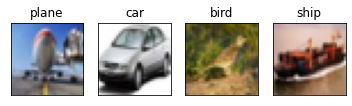

In [11]:
show_images(train_set_iter)

**Build Model**

In [26]:
class CNN(nn.Module):
    def __init__(self, training_dataset: DataLoader, testing_dataset: DataLoader):

        # parent init
        super().__init__()

        # General variables
        self.is_debug  = False # By default False

        # Data set
        self.training_dataset = training_dataset
        self.testing_dataset = testing_dataset

        # Common layers
        self.pool = nn.MaxPool2d(2)

        # Block 1
        self.conv11 = nn.Conv2d(3, 32, 3)
        self.conv12 = nn.Conv2d(32, 32, 3)

        # Block 2
        self.conv21 = nn.Conv2d(32, 64, 3)
        self.conv22 = nn.Conv2d(64, 64, 3)

        # Block 3
        self.conv31 = nn.Conv2d(64, 128, 3)
        self.conv32 = nn.Conv2d(128, 128, 3)

        # Full connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

        # Get the network on GPU/CPU
        self.to(DEVICE)
        
        return

    def forward(self, x, is_debug: bool = False):
        # Block 1 Layer 1
        x = F.relu(self.conv11(x))
        x = F.pad(x, (1, 1, 1, 1))
        self.__debug_print(x.size())

        # Block 1 Layer 2
        x = F.relu(self.conv12(x))
        x = F.pad(x, (1, 1, 1, 1))
        self.__debug_print(x.size())

        # Block 1 Layer 3
        x = self.pool(x)
        self.__debug_print(x.size())

        # Block 2 Layer 1
        x = F.relu(self.conv21(x))
        x = F.pad(x, (1, 1, 1, 1))
        self.__debug_print(x.size())

        # Block 2 Layer 2
        x = F.relu(self.conv22(x))
        x = F.pad(x, (1, 1, 1, 1))
        self.__debug_print(x.size())

        # Block 2 Layer 3
        x = self.pool(x)
        self.__debug_print(x.size())

        # Block 3 Layer 1
        x = F.relu(self.conv31(x))
        x = F.pad(x, (1, 1, 1, 1))
        self.__debug_print(x.size())

        # Block 3 Layer 2
        x = F.relu(self.conv32(x))
        x = F.pad(x, (1, 1, 1, 1))
        self.__debug_print(x.size())

        # Block 3 Layer 3
        x = self.pool(x)
        self.__debug_print(x.size())

        # reshaping
        x = x.view(x.shape[0], -1)
        self.__debug_print(x.size())

        # Fully connected layer 1
        x = F.relu(self.fc1(x))
        self.__debug_print(x.size())

        # Fully connected layer 2
        x = F.softmax(self.fc2(x), dim=1)
        self.__debug_print(x.size())
        
        return x

    def __debug_print(self, x):
        if self.is_debug:
            print(str(x))
        return

    def debug(self, C: int, W: int, H: int):
        print(self)
        self.is_debug = True # Turn Debug Flag On

        # Generate a random data
        x = torch.randn(C,W,H).view(-1,C,W,H)
        x = x.to(DEVICE)

        # Feed Forward
        self.forward(x, True)

        self.is_debug = False # Turn Debug Flag Off
        return

    def fit(self, criterion: Callable, optimizer: optim, epochs: int = 100):
        
        running_loss_list = []

        epoch = trange(epochs, desc="Epochs")

        for i in epoch:
            
            running_loss = 0

            # Loop through training set
            for data in tqdm(self.training_dataset, desc="Batch Training", leave=False):

                # separate images and their lables
                X = data[0].to(DEVICE)
                y = data[1].to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Feed forward
                y_ = self.forward(X)
                loss = criterion(y_, y)

                # back-propogate
                loss.backward()

                # take one step for optimization
                optimizer.step()

                # append loss
                running_loss += loss.item()
            
            # append loss
            running_loss = round(running_loss,2)
            running_loss_list.append(running_loss)
            epoch.set_postfix_str(f"loss = {str(running_loss)}")

        # Plot the loss
        plt.plot(running_loss_list)
        plt.xlabel("Epochs")
        plt.ylabel("Running Loss")
        plt.title("CNN Training")
        plt.show()

        return

    def save_model(self, model_name: str):
        torch.save(self, "{}{}".format(paths["model_dir"], model_name))
        return

    def load_model(self, model_name: str):
        self = torch.load("{}{}".format(paths["model_dir"], model_name))
        return

    def eval(self):
        correct = 0
        total = 0
        
        # Stop gradient updation
        with torch.no_grad():

            # Loop through testing set
            for data in tqdm(self.testing_dataset, desc="Batch Evaluating", leave=False):
                
                # separate images and their lables
                X = data[0].to(DEVICE)
                y = data[1].to(DEVICE)
                
                # Get output
                y_ = self.forward(X)

                # Check for all the Ys
                for idx, i in enumerate(y_):
                    if torch.argmax(i) == y[idx]:
                        correct += 1
                    total += 1
        
        print(f"Accuracy: {str(round(correct/total * 100, 2))}%")
        return

**Make Model**

In [27]:
cnn = CNN(train_set, test_set)

In [28]:
cnn.debug(3,32,32)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 128, 8, 8])
torch.Size([1, 128, 8, 8])
torch.Size([1, 128, 4, 4])
torch.Size([1, 2048])
torch.Size([1, 128])
torch.Size([1, 10])


**Train Model**

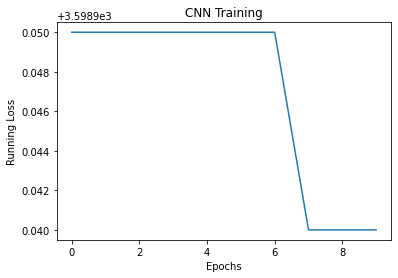

In [29]:
cnn.fit(criterion=nn.CrossEntropyLoss(), 
        optimizer=optim.SGD(cnn.parameters(), lr=1e-3, momentum=9e-1), 
        epochs=10)

**Evaluate Model**

In [30]:
cnn.eval()

Accuracy: 10.0%
